In [ ]:
# 라이브러리 임포트트
import json
import os
import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import yaml



In [3]:
with open('G:\\다른 컴퓨터\\내 노트북\\ai\\gogo v3\\AI_relay\\data\\datasets\\Training\\json_label\\E02_EE01_221110_T001_CH01_X01_f002350.json') as f:
    data = json.load(f)
print(data)

{'metaData': {'id': 'E02_EE01_221110_T001_CH01_X01_f002350', '스포츠종목': '축구', '집단행동클래스': '슈팅성공', '집단행동논리규칙': 'ERB'}, 'annotation': [{'polygon': {'type': 'polygon', 'location': [{'x1': 1829, 'y1': 367, 'x2': 1807, 'y2': 529, 'x3': 1867, 'y3': 459, 'x4': 1885, 'y4': 339}], 'label': '골대'}}, {'polygon': {'type': 'polygon', 'location': [{'x1': 1889, 'y1': 431, 'x2': 1703, 'y2': 390, 'x3': 1354, 'y3': 516, 'x4': 1725, 'y4': 618}], 'label': '골에어리어'}}, {'polygon': {'type': 'polygon', 'location': [{'x1': 1911, 'y1': 406, 'x2': 1559, 'y2': 336, 'x3': 1168, 'y3': 397, 'x4': 679, 'y4': 488, 'x5': 1099, 'y5': 659, 'x6': 1514, 'y6': 817, 'x7': 1726, 'y7': 616, 'x8': 1817, 'y8': 516}], 'label': '페널티에어리어'}}, {'polygon': {'type': 'polygon', 'location': [{'x1': 1132, 'y1': 401, 'x2': 1128, 'y2': 383, 'x3': 1150, 'y3': 366, 'x4': 1191, 'y4': 356, 'x5': 1244, 'y5': 352, 'x6': 1311, 'y6': 352, 'x7': 1392, 'y7': 353, 'x8': 1426, 'y8': 357}], 'label': '페널티아크'}}, {'polygon': {'type': 'polygon', 'location': [{'x

In [ ]:
#json 형식 데이터 yolo 형식으로 변환
datatype=["Training","Validation"]
for data_type in datatype:
    label_folder_path = f"G:\\다른 컴퓨터\\내 노트북\\ai\\gogo v3\\AI_relay\\data\\datasets\\{data_type}\\json_label\\"
    image_folder_pah = f"G:\\다른 컴퓨터\\내 노트북\\ai\\gogo v3\\AI_relay\\data\\datasets\\{data_type}\\images\\"
    output_folder_path = f"G:\\다른 컴퓨터\\내 노트북\\ai\\gogo v3\\AI_relay\\data\\datasets\\{data_type}\\txt_label"
    file_list = os.listdir(label_folder_path)
    class_dict = {"선수": 0, "공": 1, "골대": 2}
    os.makedirs(output_folder_path, exist_ok=True)

    for file in tqdm.tqdm(file_list, desc=f"Converting {data_type} labels"):
        if not file.endswith(".json"):
            continue
        
        with open(os.path.join(label_folder_path, file), "r", encoding="utf-8") as f:
            data = json.load(f)

        # 이미지 정보
        img_width = data["imageinfo"]["width"]
        img_height = data["imageinfo"]["height"]
        
        yolo_label_path = os.path.join(output_folder_path, file.replace(".json", ".txt"))
        
        with open(yolo_label_path, "w") as yolo_file:
            for obj in data["annotation"]:
                if "box" in obj:  # 선수, 공
                    label = obj["box"]["label"]
                    if label in class_dict:
                        points = obj["box"]["location"][0]
                        x, y, width, height = points["x"], points["y"], points["width"], points["height"]

                        # 정규화
                        x_center = (x + width / 2) / img_width
                        y_center = (y + height / 2) / img_height
                        width /= img_width
                        height /= img_height

                        # YOLO 포맷 저장
                        yolo_file.write(f"{class_dict[label]} {x_center} {y_center} {width} {height}\n")

                elif "polygon" in obj and obj["polygon"]["label"] == "골대":  # 골대 (Polygon → BBox 변환)
                    points = obj["polygon"]["location"][0]
                    x_values = [points[f"x{i}"] for i in range(1, len(points) // 2 + 1)]
                    y_values = [points[f"y{i}"] for i in range(1, len(points) // 2 + 1)]

                    x_min, x_max = min(x_values), max(x_values)
                    y_min, y_max = min(y_values), max(y_values)
                    width = x_max - x_min
                    height = y_max - y_min
                    x_center = (x_min + width / 2) / img_width
                    y_center = (y_min + height / 2) / img_height
                    width /= img_width
                    height /= img_height

                    # YOLO 포맷 저장
                    yolo_file.write(f"{class_dict['골대']} {x_center} {y_center} {width} {height}\n")

print("YOLO 라벨 변환 완료!")

Converting Validation labels: 100%|██████████| 375/375 [01:07<00:00,  5.55it/s]

✅ YOLO 라벨 변환 완료!


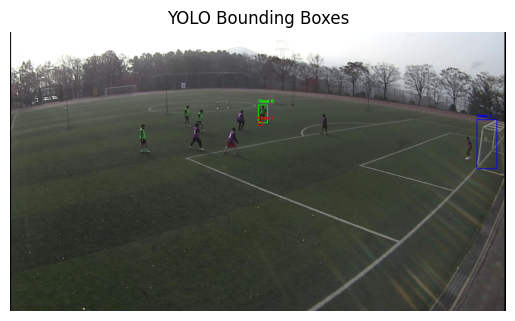

In [ ]:
# yolo 라벨을 이미지에 표시

image_folder_path = r"G:\\다른 컴퓨터\\내 노트북\\ai\\gogo v3\\AI_relay\\data\\datasets\\Training\\images\\"  # 이미지 폴더
label_folder_path = r"G:\\다른 컴퓨터\\내 노트북\\ai\\gogo v3\\AI_relay\\data\\datasets\\Training\\txt_label\\"  # YOLO 라벨 폴더
image_filename = "E02_EE01_221110_T001_CH01_X01_f002350.jpg"  # 이미지 파일명,


class_colors = {
    0: (0, 255, 0),  # 선수 - 초록색
    1: (0, 0, 255),  # 공 - 빨간색
    2: (255, 0, 0)   # 골대 - 파란색
}

image_path = os.path.join(image_folder_path, image_filename)
label_path = os.path.join(label_folder_path, image_filename.replace(".jpg", ".txt"))

if not os.path.exists(image_path):
    raise FileNotFoundError(f"이미지 파일이 존재하지 않습니다: {image_path}")

image_array = np.fromfile(image_path, dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
if image is None:
    raise ValueError(f"이미지를 불러올 수 없습니다. 파일 경로를 확인하세요: {image_path}")

img_height, img_width, _ = image.shape

# YOLO 라벨 불러오기
if not os.path.exists(label_path):
    print("라벨 파일이 존재하지 않습니다.")
    exit()

with open(label_path, "r") as f:
    lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])

        # 원래 좌표로 변환
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)

        # Bounding Box 그리기
        color = class_colors.get(class_id, (255, 255, 255))  # 기본 색상: 흰색
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        label_text = f"Class {class_id}"
        cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")
plt.title("YOLO Bounding Boxes")
plt.show()


In [ ]:
# yolo.yaml 파일 생성
data = {
    "path" : 'G:\\다른 컴퓨터\\내 노트북\\ai\\gogo v3\\AI_relay\\data\\datasets',
    "train" : '\\Training\\',
        "val" : '\\Validation\\',
        "names" : {0 : 'player', 1 : 'ball', 2 : 'goalpost'}}

with open('G:\\다른 컴퓨터\\내 노트북\\ai\\gogo v3\\AI_relay\\yolo.yaml', 'w') as f :
    yaml.dump(data, f)

with open('G:\\다른 컴퓨터\\내 노트북\\ai\\gogo v3\\AI_relay\\yolo.yaml', 'r') as f :
    lines = yaml.safe_load(f)
    print(lines)

{'names': {0: 'player', 1: 'ball', 2: 'goalpost'}, 'path': 'G:\\다른 컴퓨터\\내 노트북\\ai\\gogo v3\\AI_relay\\data\\datasets', 'train': '\\Training\\', 'val': '\\Validation\\'}
